In [21]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [102]:
colors = {"tblis" : "olive", "gsl" : "green", "blas" : "red", "taco" : "blue", "gsl_tensor" : "cyan", \
          "dot_blas" : "gold", "dot_gsl" : "grey", "gemv_blas" : "purple", "gemv_gsl" : "pink", "mkl" :"black", "cuda":"green",\
         "dot_mkl" : "silver", "gemv_mkl" : "yellow", "stardust":"orange"}

markers = {"tblis" : "o", "gsl" : "p", "blas" : "*", "taco" : ".", "gsl_tensor" : ".", \
          "dot_blas" : ".", "dot_gsl" : ".", "gemv_blas" : ".", "gemv_gsl" : "p", "mkl" :"v", "cuda":"s",\
         "dot_mkl" : ".", "gemv_mkl" : ".", "stardust":"1"}
                      
linestyles = {"tblis" : "-", "gsl" : "-", "blas" : "-", "taco" : "-", "gsl_tensor" : "-", \
          "dot_blas" : "-", "dot_gsl" : "-", "gemv_blas" : "-", "gemv_gsl" : "-", "mkl" :"--", "cuda":"-",\
         "dot_mkl" : "-", "gemv_mkl" : "-", "stardust":"-"}

In [131]:
def save_plots_seperate(name, directory, systems, expr, interval, start, split, result_dir="", stardust=None, filtered=None):
    
    result = None
    
    for system in systems:
        data = json.load(open(f'{directory}/{name}/{result_dir}/{system}'))
        df = pd.DataFrame(data["benchmarks"])
        df = df[df['aggregate_name'] == "median"]['real_time']
        df = df.reset_index(drop=True)
        df = df.rename_axis('dimension').reset_index()
        df['dimension'] = df['dimension']*interval + start
        
        df.rename(columns = {'real_time': f'{system}_real_time'}, inplace = True)
        
        if result is None:
            result = df
        else:
            result = pd.merge(result, df, on='dimension', how='outer')
        
    if stardust is not None:
        data = pd.read_csv("../stardust-runs/spmv_plus2.csv")
        if stardust == "SpMV":
            df = pd.DataFrame(data[["app", "cycles", "dim_0_2"]])
            df.rename(columns = {'dim_0_2': f'dimension'}, inplace = True)
        else:
            df = pd.DataFrame(data[["app", "cycles", "dataset"]])
        # Stardust cycles are in ns and call to it takes 0.0002 ms
        df[df['app'] == stardust]
        df['cycles'] = df['cycles'] *1e-6 + 0.0002
        print(df)
#         df = df.reset_index(drop=True)
#         df = df.rename_axis('dimension').reset_index()
#         df['dimension'] = df['dimension']*interval + start
        df.rename(columns = {'cycles': f'stardust_real_time'}, inplace = True)
        result = pd.merge(result, df, on='dimension', how='outer')
        systems.append("stardust")
        
    if filtered is not None: 
        for system in filtered:
            data = pd.read_csv(f'{directory}/{name}/{result_dir}/{system}_filter')
            df = data['real_time']
            df = df.reset_index(drop=True)
            df = df.rename_axis('dimension').reset_index()
            df['dimension'] = df['dimension']*interval + start
        
            df.rename(columns = {'real_time': f'{system}_real_time'}, inplace = True)
            result = pd.merge(result, df, on='dimension', how='outer')
        systems = systems + filtered
            
        
    full_plt = result.plot(kind = 'line', x = 'dimension', y = [f'{i}_real_time' for i in systems],  
                           color=[colors[system] for system in systems], 
                           #marker='plot_marker',
                           title=expr)
    
    for i, line in enumerate(full_plt.get_lines()):
        line.set_marker(markers[systems[i]])
        line.set_linestyle(linestyles[systems[i]])

    plt.ylabel('Real Time (ms)')
    plt.xlabel('Dimension')
    
    plt.savefig(f'{directory}/{name}/{result_dir}/raw_graph.svg', format="svg")

    f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    result.plot(kind = 'line', x = 'dimension', y = [f'{i}_real_time' for i in systems], color=[colors[system] for system in systems], ax=ax)
    result.plot(kind = 'line', x = 'dimension', y = [f'{i}_real_time' for i in systems], color=[colors[system] for system in systems], ax=ax2)    
    
    full_plt = result.plot(kind = 'line', x = 'dimension', y = [f'{i}_real_time' for i in systems],  color=[colors[system] for system in systems], title=expr)
    
    for i, line in enumerate(full_plt.get_lines()):
        line.set_marker(markers[systems[i]])
        line.set_linestyle(linestyles[systems[i]])
    full_plt.legend(full_plt.get_lines(), [f'{i}_real_time' for i in systems])

    plt.yscale("log")
    plt.ylabel('Real Time (ms)')
    plt.xlabel('Dimension')
    
    plt.savefig(f'{directory}/{name}/{result_dir}/log_graph.svg', format="svg")
    
    

In [118]:
def save_plots_seperate_sparsity(name, directory, systems, expr, split, sparse, result_dir=""):
    
    result = None
    
    for system in systems:
        data = json.load(open(f'{directory}/{name}/{result_dir}/{system}'))
        df = pd.DataFrame(data["benchmarks"])
        df = df.reset_index(drop=True)
        df = df.rename_axis('sparisty').reset_index()
        df.rename(columns = {'real_time': f'{system}_real_time'}, inplace = True)
        
        if result is None:
            result = df
        else:
            result = pd.merge(result, df, on='sparisty', how='outer')
        
    
    sparse = [str(i) for i in sparse]
    result['sparisty'] = sparse
    full_plt = result.plot(kind = 'line', x = 'sparisty', y = [f'{i}_real_time' for i in systems],  color=[colors[system] for system in systems], title=expr)

    for i, line in enumerate(full_plt.get_lines()):
        line.set_marker(markers[systems[i]])
        line.set_linestyle(linestyles[systems[i]])
    full_plt.legend(full_plt.get_lines(), [f'{i}_real_time' for i in systems])
        
    plt.ylabel('Real Time (ms)')
    plt.xlabel('sparisty')
    
    plt.savefig(f'{directory}/{name}/{result_dir}/raw_graph.svg', format="svg")

    f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    result.plot(kind = 'line', x = 'sparisty', y = [f'{i}_real_time' for i in systems], color=[colors[system] for system in systems], ax=ax)
    result.plot(kind = 'line', x = 'sparisty', y = [f'{i}_real_time' for i in systems], color=[colors[system] for system in systems], ax=ax2)
    
    maximum = max([result[f'{i}_real_time'].max() for i in systems])
    
    
    ax2.set_ylim(0, split) 
    ax.set_ylim(split, maximum)
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    
    f.suptitle(expr)
    plt.ylabel('Real Time (ms)')
    plt.xlabel('sparisty')
        
    plt.savefig(f'{directory}/{name}/{result_dir}/split_graph.svg', format="svg")
    
    
    full_plt = result.plot(kind = 'line', x = 'sparisty', y = [f'{i}_real_time' for i in systems],  color=[colors[system] for system in systems], title=expr)
    for i, line in enumerate(full_plt.get_lines()):
        line.set_marker(markers[systems[i]])
        line.set_linestyle(linestyles[systems[i]])
    full_plt.legend(full_plt.get_lines(), [f'{i}_real_time' for i in systems])
    
    plt.yscale("log")
    plt.ylabel('Real Time (ms)')
    plt.xlabel('sparisty')
    
    plt.savefig(f'{directory}/{name}/{result_dir}/log_graph.svg', format="svg")

          app    cycles  dimension
0    Plus2CSR  0.000831        NaN
1    Plus2CSR  0.000753        NaN
2    Plus2CSR  0.000751        NaN
3    Plus2CSR  0.001632        NaN
4    Plus2CSR  0.002798        NaN
..        ...       ...        ...
105      SpMV  0.089186        NaN
106      SpMV       NaN        NaN
107      SpMV  0.002537        NaN
108      SpMV  0.001453      750.0
109      SpMV  0.001298        NaN

[110 rows x 3 columns]


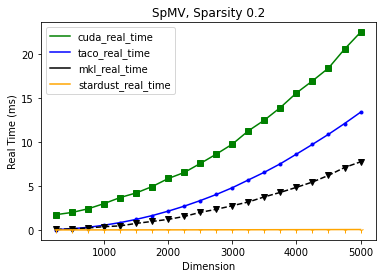

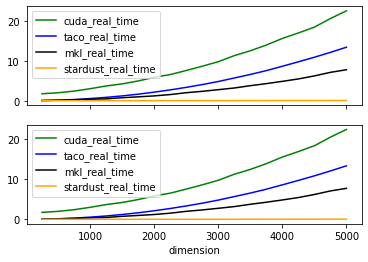

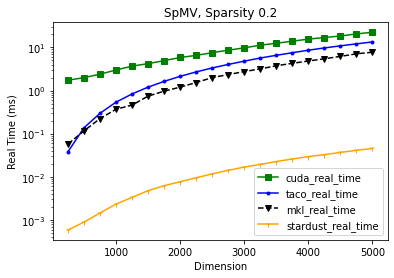

In [119]:
save_plots_seperate("spmv", "./", \
                     ["cuda", "taco", "mkl"],\
                     "SpMV, Sparsity 0.2", 250, 250, 0.5, stardust="SpMV")

In [127]:
def filter_data(name, directory, system, result_dir=""):
    data = json.load(open(f'{directory}/{name}/{result_dir}/{system}'))
    df = pd.DataFrame(data["benchmarks"])
    df = df[df['aggregate_name'] == "median"][['real_time', 'run_name']]
    df = df.iloc[::2]
    print(df)
    df.to_csv(f'{directory}/{name}/{result_dir}/{system}_filter')

filter_data("sddmm_dim", "./", "dot_blas")

       real_time                                           run_name
1       0.703599  bench_sddmm_dot_blas/100/min_warmup_time:10.00...
9      15.289971  bench_sddmm_dot_blas/300/min_warmup_time:10.00...
17    103.900145  bench_sddmm_dot_blas/500/min_warmup_time:10.00...
25    353.793073  bench_sddmm_dot_blas/700/min_warmup_time:10.00...
33    771.866653  bench_sddmm_dot_blas/900/min_warmup_time:10.00...
41   1412.266965  bench_sddmm_dot_blas/1100/min_warmup_time:10.0...
49   3527.743637  bench_sddmm_dot_blas/1300/min_warmup_time:10.0...
57  11494.909714  bench_sddmm_dot_blas/1500/min_warmup_time:10.0...
65  33472.183996  bench_sddmm_dot_blas/1700/min_warmup_time:10.0...
73  68791.151835  bench_sddmm_dot_blas/1900/min_warmup_time:10.0...


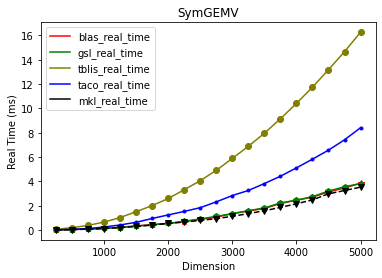

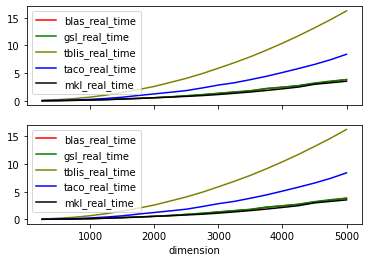

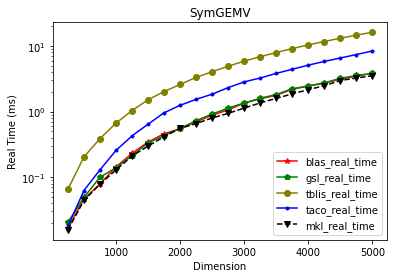

In [83]:
save_plots_seperate("symmgemv", "./", \
                     ["blas", "gsl", "tblis", "taco", "mkl"],\
                     "SymGEMV", 250, 250, 0.5)

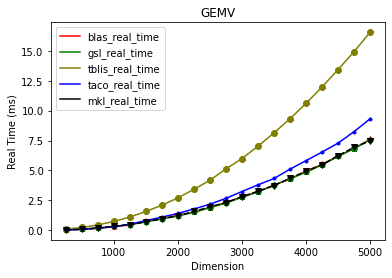

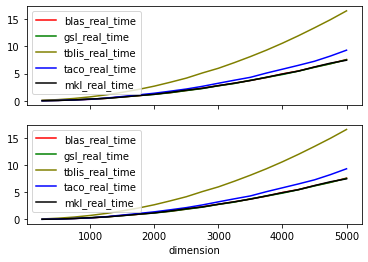

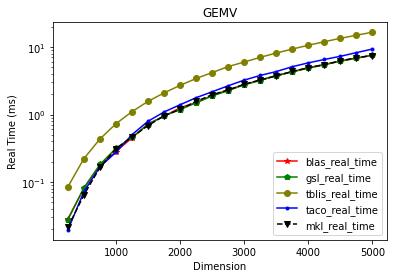

In [84]:
save_plots_seperate("gemv", "./", \
                     ["blas", "gsl", "tblis", "taco", "mkl"],\
                     "GEMV", 250, 250, 0.5)

/tmp/ipykernel_272924/3031784247.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'iterations_x', 'time_unit_x', 'repetition_index_x', 'cpu_time_x', 'name_x', 'threads_x', 'per_family_instance_index_x', 'repetitions_x', 'family_index_x', 'run_name_x', 'run_type_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = pd.merge(result, df, on='sparisty', how='outer')
/tmp/ipykernel_272924/3031784247.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'iterations_x', 'time_unit_x', 'repetition_index_x', 'cpu_time_x', 'name_x', 'threads_x', 'per_family_instance_index_x', 'repetitions_x', 'family_index_x', 'run_name_x', 'run_type_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = pd.merge(result, df, on='sparisty', how='outer')


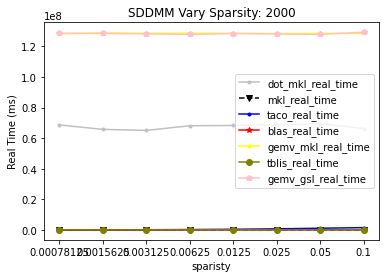

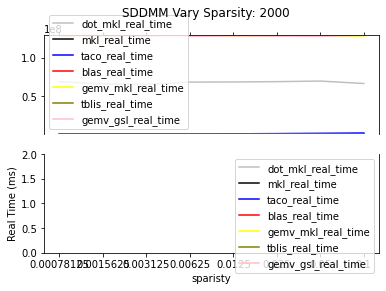

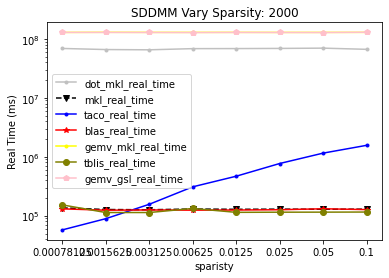

In [85]:
save_plots_seperate_sparsity("sddmm_varSparsity", "./", \
                             ["dot_mkl", "mkl","taco", "blas", "gemv_mkl", "tblis", "gemv_gsl"], \
                             "SDDMM Vary Sparsity: 2000", 2,  [0.00078125, 0.0015625, 0.003125, 0.00625, 0.0125, 0.025, 0.05, 0.1])

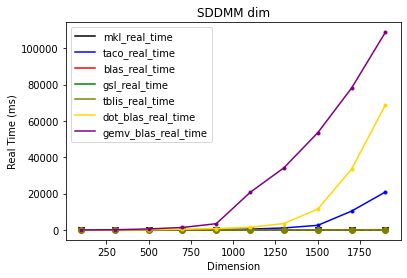

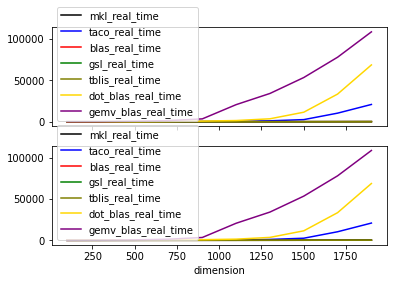

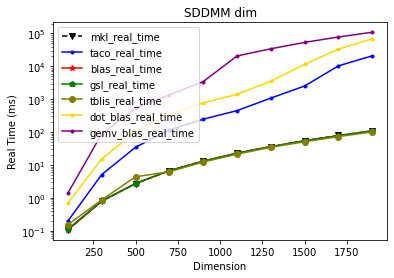

In [132]:

save_plots_seperate("sddmm_dim", "./", \
                     [ "mkl","taco", "blas", "gsl", "tblis"],\
                     "SDDMM dim", 200, 100, 0.5, filtered=["dot_blas", "gemv_blas"])

In [140]:
filter_data("blockedSparse_4T", "./", "taco")
filter_data("blockedSparse_4T", "./", "blas")


        real_time                                           run_name
1        0.164888  bench_blockedSparse4T_taco/10/iterations:1/rep...
9        6.847039  bench_blockedSparse4T_taco/20/iterations:1/rep...
17      97.225798  bench_blockedSparse4T_taco/30/iterations:1/rep...
25     702.042853  bench_blockedSparse4T_taco/40/iterations:1/rep...
33    2381.226146  bench_blockedSparse4T_taco/50/iterations:1/rep...
41    8102.545853  bench_blockedSparse4T_taco/60/iterations:1/rep...
49   32789.677522  bench_blockedSparse4T_taco/70/iterations:1/rep...
57  172299.123398  bench_blockedSparse4T_taco/80/iterations:1/rep...
65  564527.194400  bench_blockedSparse4T_taco/90/iterations:1/rep...
        real_time                                           run_name
1        0.185612  bench_blockedSparse4T_blas/10/iterations:1/rep...
9        5.030594  bench_blockedSparse4T_blas/20/iterations:1/rep...
17      48.682904  bench_blockedSparse4T_blas/30/iterations:1/rep...
25     566.724963  bench_blockedSp

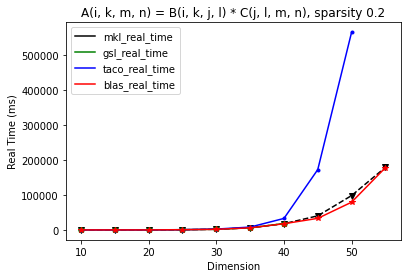

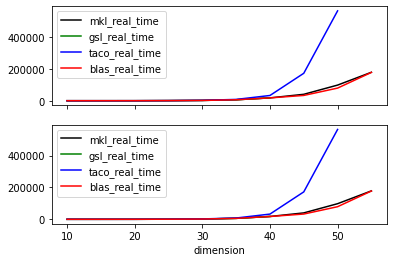

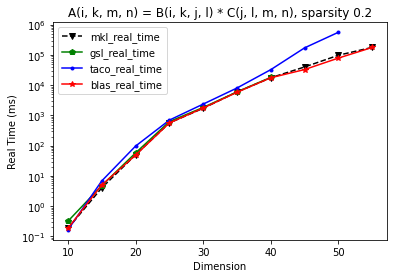

In [141]:

save_plots_seperate("blockedSparse_4T", "./", ["mkl", "gsl"],\
                    "A(i, k, m, n) = B(i, k, j, l) * C(j, l, m, n), sparsity 0.2", 5, 10, 0.5, filtered=["taco", "blas"])